In [227]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
from pyfaidx import Fasta
import upsetplot
from pandarallel import pandarallel

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [228]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [229]:
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [230]:
p_df = pd.read_csv(proc_cfg(config['lr']['poder_protein']['protein']['summary'], od), sep='\t')
p_df = p_df.merge(mt_df[['associated_gene_biotype',
                         'structural_category', 
                         'associated_transcript',
                         'isoform',
                         'associated_gene',
                         'length']],
                  how='left',
                  left_on='tid', 
                  right_on='isoform')
p_df.rename({'associated_gene':'gid',
             'protein_sequence':'seq'}, axis=1, inplace=True)
assert len(p_df.loc[p_df.isoform.isnull()]) == 0

## First, need to filter

In [231]:
# keep only things from annotated protein coding genes
p_df = p_df.loc[p_df.associated_gene_biotype=='Protein Coding']
n = len(p_df.index)
print(len(p_df.index))

# keep only things w/ full ORFs
p_df = p_df.loc[(p_df.protein_has_start_codon==True)&\
                (p_df.protein_has_stop_codon==True)]
print(len(p_df.index))


# remove NMD things
p_df = p_df.loc[p_df.protein_is_nmd == False]
print(len(p_df.index))
n2 = len(p_df.index)

print()
print(n)
print(n2)
print((n2/n)*100)
print(((n-n2)/n)*100)


# length minimum?? maybe not
print(len(p_df.index))

100666
100666
86306

100666
86306
85.7350048675819
14.264995132418095
86306


## Merge reference AA sequences on gid + sequence

In [232]:
# get annotated AA sequencesa
fasta_file = proc_cfg(config['ref']['pc'], od)
fasta = Fasta(fasta_file)

# Extract each entry's name and sequence
ref_orfs = {
    "name": [entry.name for entry in fasta],
    "seq": [str(entry) for entry in fasta]
}

ref_orfs = pd.DataFrame(ref_orfs)
ref_orfs['gid'] =  ref_orfs.name.str.split('|', expand=True)[2]
ref_orfs = ref_orfs[['seq', 'gid']]
ref_orfs['annot_aa'] = True
ref_orfs.drop_duplicates(inplace=True)

# just going to call novel aas as those that are not in the 
# pc translations gencode file
print(len(p_df))
p_df = p_df.merge(ref_orfs, how='left', on=['gid', 'seq'])
print(len(p_df))
p_df['annot_aa'] = p_df['annot_aa'].fillna(False)
p_df.head()

86306
86306


,Chromosome,Start,Stop,Strand,Source,CDS_Source,CDS_Start,CDS_Stop,tid,pid,...,protein_has_stop_codon,protein_has_start_codon,seq,associated_gene_biotype,structural_category,associated_transcript,isoform,gid,length,annot_aa
0,chr12,4590319,4613888,+,ENSEMBL,ORFanage,4591180,4613750,ENST00000010132.6,ENSP00000010132.5,...,True,True,MPASELKASEIPFHPSIKTQDPKAEEKSPKKQKVTLTAAEALKLFK...,Protein Coding,FSM,ENST00000010132.6,ENST00000010132.6,ENSG00000010219.14,1840,True
1,chr12,7919229,7936187,-,HAVANA,ORFanage,7921415,7936034,ENST00000075120.12,ENSP00000516774.1,...,True,True,MGTQKVTPALIFAITVATIGSFQFGYNTGVINAPEKIIKEFINKTL...,Protein Coding,FSM,ENST00000075120.12,ENST00000075120.12,ENSG00000059804.18,3827,True
2,chrY,2935380,2982506,+,HAVANA,ORFanage,2953936,2979990,ENST00000155093.8,ENSP00000155093.3,...,True,True,MDEDEFELQPQEPNSFFDGIGADATHMDGDQIVVEIQEAVFVSNIV...,Protein Coding,FSM,ENST00000155093.8,ENST00000155093.8,ENSG00000067646.12,5336,True
3,chrX,48922210,48957631,-,HAVANA,ORFanage,48923176,48957570,ENST00000156084.8,ENSP00000156084.4,...,True,True,MTILPKKKPPPPDADPANEPPPPGPMPPAPRRGGGVGVGGGGTGVG...,Protein Coding,FSM,ENST00000156084.8,ENST00000156084.8,ENSG00000068308.15,2740,True
4,chr6,155395367,155455839,-,HAVANA,ORFanage,155396838,155455800,ENST00000159060.3,ENSP00000159060.2,...,True,True,MMGCWILNEGLSTILVLSWLGINFYLFIDTFYWYEEEESFHYTRVI...,Protein Coding,FSM,ENST00000159060.3,ENST00000159060.3,ENSG00000074771.4,1980,True


In [233]:
p_df[['isoform', 'annot_aa', 'structural_category']].groupby(['annot_aa', 'structural_category']).nunique()

isoform
annot_aa structural_category         
False    FSM                    23236
         NIC                    10369
         NNC                    12302
True     FSM                    34936
         NIC                     2647
         NNC                     2816

## Get our own protein sequence novelty categories
1. exact AA match
2. truncated AA match
3. novel, non-truncation AA seq

In [234]:
# # 2. truncated AA match
# def get_aa_seq_truncations(x, ref_orfs):
#     # limit to just references from same gene
#     temp = ref_orfs.loc[ref_orfs.gid == x.gid]
#     for ind, entry in temp.iterrows():
#         if x.seq in entry.seq:
#             return True
#     return False

# p_df['trunc_annot_aa'] = p_df.apply(lambda x: get_aa_seq_truncations(x, ref_orfs), axis=1)


# # smol_p_df = p_df.loc[p_df.annot_aa==False].head(20)
# # smol_p_df['trunc_annot_aa'] = smol_p_df.apply(lambda x: get_aa_seq_truncations(x, ref_orfs), axis=1)
# # pandarallel.initialize(nb_workers=8, verbose=1)
# # p_df = p_df.parallel_apply(get_aa_seq_truncations, args=(ref_orfs), axis=1, progress_bar=False)

In [235]:
# seq = smol_p_df.loc[smol_p_df.trunc_annot_aa==True].head(1).seq.tolist()[0]
# gid = smol_p_df.loc[smol_p_df.trunc_annot_aa==True].head(1).gid.tolist()[0]
# temp_ref_orfs = ref_orfs.loc[ref_orfs.gid==gid, 'seq'].tolist()

In [236]:
# 3. the rest are non-matching

In [237]:
# p_df.to_csv('orf_thing.tsv', sep='\t')

In [238]:
p_df = pd.read_csv('orf_thing.tsv', sep='\t')

In [239]:
p_df['aa_seq_novelty'] = 'Novel'
p_df.loc[(p_df.annot_aa==True), 'aa_seq_novelty'] = 'Known'
p_df.loc[(p_df.annot_aa==False)&\
         (p_df.trunc_annot_aa==True), 'aa_seq_novelty'] = 'Truncation'

In [240]:
# add status of fsm cdss


# get annotated AA sequencesa
fasta_file = proc_cfg(config['ref']['pc'], od)
fasta = Fasta(fasta_file)

# Extract each entry's name and sequence
ref_orfs = {
    "name": [entry.name for entry in fasta],
    "seq": [str(entry) for entry in fasta]
}

ref_orfs = pd.DataFrame(ref_orfs)
ref_orfs['gid'] =  ref_orfs.name.str.split('|', expand=True)[2]
ref_orfs['tid'] = ref_orfs.name.str.split('|', expand=True)[1]
ref_orfs.head()


,name,seq,gid,tid
0,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,MKKVTAEAISWNESTSETNNSMVTEFIFLGLSDSQELQTFLFMLFF...,ENSG00000186092.7,ENST00000641515.2
1,ENSP00000409316.1|ENST00000426406.4|ENSG000002...,MDGENHSVVSEFLFLGLTHSWEIQLLLLVFSSVLYVASITGNILIV...,ENSG00000284733.2,ENST00000426406.4
2,ENSP00000329982.2|ENST00000332831.5|ENSG000002...,MDGENHSVVSEFLFLGLTHSWEIQLLLLVFSSVLYVASITGNILIV...,ENSG00000284662.2,ENST00000332831.5
3,ENSP00000478421.2|ENST00000616016.5|ENSG000001...,MPAVKKEFPGREDLALALATFHPTLAALPLPPLPGYLAPLPAAAAL...,ENSG00000187634.13,ENST00000616016.5
4,ENSP00000480678.2|ENST00000618323.5|ENSG000001...,MPAVKKEFPGREDLALALATFHPTLAALPLPPLPGYLAPLPAAAAL...,ENSG00000187634.13,ENST00000618323.5


In [241]:
p_df.loc[~(p_df.isoform.isin(ref_orfs.tid.tolist()))&\
         (p_df.structural_category=='FSM'),'structural_category'] = 'FSM w/o CDS'
# p_df.loc[(p_df.structural_category=='FSM')&\
#          (p_df.annot_cds==False), 'aa_seq_novelty'] = 'FSM w/o CDS'

In [242]:
p_df.to_csv('241120_long_struct_cat_aa_cat.tsv', sep='\t')

In [243]:
temp = p_df[['isoform', 'aa_seq_novelty', 'structural_category']].groupby(['aa_seq_novelty', 'structural_category']).nunique().rename({'isoform':'n_t'}, axis=1)
temp = temp.reset_index()
temp

,aa_seq_novelty,structural_category,n_t
0,Known,FSM,2580
1,Known,FSM w/o CDS,32356
2,Known,NIC,2647
3,Known,NNC,2816
4,Novel,FSM,279
5,Novel,FSM w/o CDS,13869
6,Novel,NIC,7325
7,Novel,NNC,9869
8,Truncation,FSM,831
9,Truncation,FSM w/o CDS,8257


<AxesSubplot:xlabel='structural_category', ylabel='n_t'>

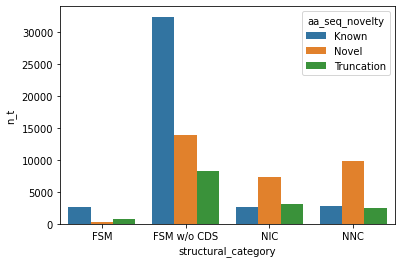

In [244]:
sns.barplot(temp, x='structural_category', hue='aa_seq_novelty', y='n_t')

In [245]:
# what about by % from each category
temp2 = p_df[['isoform', 'structural_category']].groupby('structural_category').nunique().rename({'isoform':'n_total_t'}, axis=1).reset_index()
temp = temp.merge(temp2, how='left', on='structural_category')
temp['perc'] = (temp['n_t']/temp['n_total_t'])*100

<AxesSubplot:xlabel='structural_category', ylabel='perc'>

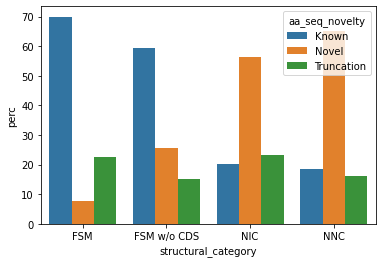

In [246]:
sns.barplot(temp, x='structural_category', hue='aa_seq_novelty', y='perc')

In [247]:
# temp.to_csv('241113_struct_cat_aa_cat.tsv', sep='\t')
temp.to_csv('241119_struct_cat_aa_cat.tsv', sep='\t')

## Number of unique gene+aa combos detected by population

In [248]:
p_df['aa_id'] = p_df.gid+'_'+p_df.seq

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])
samples = [s for s in meta['sample'].tolist() if s in mt_df.columns]

temp = mt_df[['isoform']+samples]
temp.rename({'isoform': 'tid'}, axis=1, inplace=True)
temp.set_index('tid', inplace=True)
temp = temp.melt(ignore_index=False, var_name='sample', value_name='detected')
temp.reset_index(inplace=True)
temp = temp.merge(meta[['sample', 'map_reads_assemblymap']], 
                  how='left',
                  on='sample')

# remove undetected things
temp = temp.loc[temp.detected!=0]

# merge in the gid_seq key and aa novelty status from p_df
temp = temp.merge(p_df[['annot_aa', 'tid', 'aa_id', 'aa_seq_novelty']],
                  how='inner', #limit to only the things we care about which are already in p_df
                  on='tid')

temp.drop(['detected', 'tid'], axis=1, inplace=True)
temp = temp.groupby(['annot_aa', 'map_reads_assemblymap', 'sample', 'aa_seq_novelty']).nunique().rename({'aa_id':'n_aa'}, axis=1).reset_index()
temp['eur_noneur'] = 'Non-European'
temp.loc[(temp['sample'].str.startswith('AJI'))|\
         (temp['sample'].str.startswith('CEU')), 'eur_noneur'] = 'European'
temp['n_aa_per_million'] = (temp.n_aa/temp.map_reads_assemblymap)*1e6


<AxesSubplot:xlabel='annot_aa', ylabel='n_aa'>

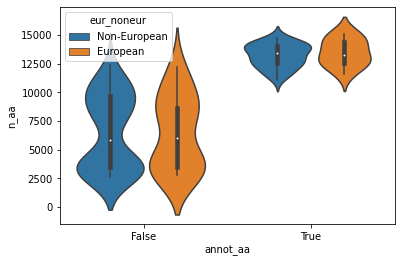

In [249]:
sns.violinplot(temp, y='n_aa', x='annot_aa', hue='eur_noneur')

<AxesSubplot:xlabel='annot_aa', ylabel='n_aa'>

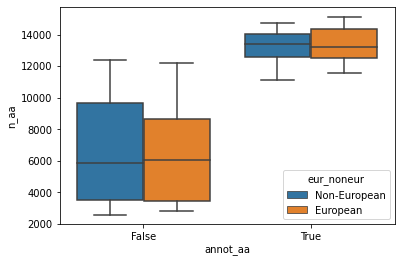

In [250]:
sns.boxplot(temp, y='n_aa', x='annot_aa', hue='eur_noneur')

In [251]:
x = temp.loc[temp.eur_noneur=='European', 'n_aa_per_million'].tolist()
y = temp.loc[temp.eur_noneur=='Non-European', 'n_aa_per_million'].tolist()
stat, pval = st.ranksums(x, y, alternative='two-sided')
print(f'Two-sided Wilcoxon rank-sum test stat: {stat}')
print(f'pval: {pval}')

Two-sided Wilcoxon rank-sum test stat: -0.04858127067234718
pval: 0.9612529961768728


<AxesSubplot:xlabel='aa_seq_novelty', ylabel='n_aa'>

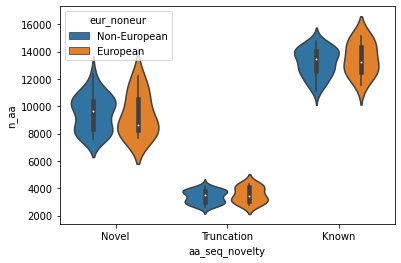

In [252]:
sns.violinplot(temp, y='n_aa', x='aa_seq_novelty', hue='eur_noneur')

In [253]:
for n in temp.aa_seq_novelty.unique().tolist():
    temp2 = temp.loc[temp.aa_seq_novelty==n].copy(deep=True)
    x = temp2.loc[temp2.eur_noneur=='European', 'n_aa_per_million'].tolist()
    y = temp2.loc[temp2.eur_noneur=='Non-European', 'n_aa_per_million'].tolist()
    stat, pval = st.ranksums(x, y, alternative='two-sided')
    print(n)
    print(f'Two-sided Wilcoxon rank-sum test stat: {stat}')
    print(f'pval: {pval}')
    print()

Novel
Two-sided Wilcoxon rank-sum test stat: -0.6680426571226848
pval: 0.5041063636520798

Truncation
Two-sided Wilcoxon rank-sum test stat: 0.3340213285613424
pval: 0.7383634642235701

Known
Two-sided Wilcoxon rank-sum test stat: 0.0
pval: 1.0



In [254]:
# what about combining FSMs and Knowns together?
temp['aa_seq_novelty_2'] = 'Known'
temp.loc[temp.aa_seq_novelty=='Novel', 'aa_seq_novelty_2'] = 'Novel'

for n in temp.aa_seq_novelty_2.unique().tolist():
    temp2 = temp.loc[temp.aa_seq_novelty_2==n].copy(deep=True)
    x = temp2.loc[temp2.eur_noneur=='European', 'n_aa_per_million'].tolist()
    y = temp2.loc[temp2.eur_noneur=='Non-European', 'n_aa_per_million'].tolist()
    stat, pval = st.ranksums(x, y, alternative='two-sided')
    print(n)
    print(f'Two-sided Wilcoxon rank-sum test stat: {stat}')
    print(f'pval: {pval}')
    print()

Novel
Two-sided Wilcoxon rank-sum test stat: -0.6680426571226848
pval: 0.5041063636520798

Known
Two-sided Wilcoxon rank-sum test stat: 0.11877113736973437
pval: 0.9054566758336993



<AxesSubplot:xlabel='aa_seq_novelty_2', ylabel='n_aa'>

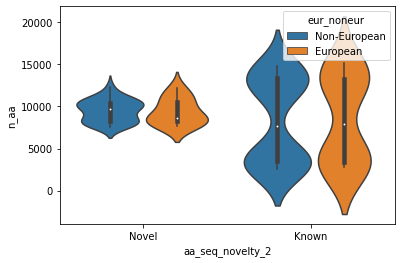

In [255]:
sns.violinplot(temp, y='n_aa', x='aa_seq_novelty_2', hue='eur_noneur')

<AxesSubplot:xlabel='aa_seq_novelty_2', ylabel='n_aa_per_million'>

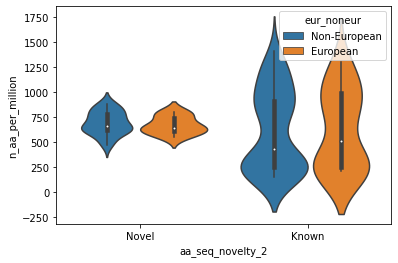

In [256]:
sns.violinplot(temp, y='n_aa_per_million', x='aa_seq_novelty_2', hue='eur_noneur')

## What % of FSM transcripts --> known AA seq? What % of novel transcripts --> novel AA seq?

In [257]:
temp = pd.read_csv('241113_struct_cat_aa_cat.tsv', sep='\t')

In [258]:
temp

,Unnamed: 0,aa_seq_novelty,structural_category,n_t,n_total_t,perc
0,0,Known,FSM,34936,58172,60.056385
1,1,Known,NIC,2647,13016,20.336509
2,2,Known,NNC,2816,15118,18.626802
3,3,Novel,FSM,14148,58172,24.320979
4,4,Novel,NIC,7325,13016,56.276890
5,5,Novel,NNC,9869,15118,65.279799
6,6,Truncation,FSM,9088,58172,15.622636
7,7,Truncation,NIC,3044,13016,23.386601
8,8,Truncation,NNC,2433,15118,16.093399


In [259]:
20.3+23.3

43.6

## What about # ORFs / gene / population between the OOA and Afr? 

In [385]:
# get expression levels for each transcript

f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
# df.set_index('tid', inplace=True)

In [386]:
temp = p_df[['tid', 'aa_id']].copy(deep=True)
temp.head()
l1 = len(temp.index)

In [387]:
temp = temp.merge(df, 
              how='inner',
              on='tid')
l2 = len(temp.index)
assert l1 == l2

In [388]:
# groupby aa_id and sum up 
temp.drop('tid', axis=1, inplace=True)
temp.groupby('aa_id').sum().reset_index()

,aa_id,YRI5,YRI6,YRI7,HAC1,HAC2,HAC3,HAC4,HAC5,HAC6,...,AJI6,CEU1,CEU2,CEU3,CEU4,CEU5,MPC4,YRI1,YRI2,YRI3
0,ENSG00000000003.16_MASPSRRLQTKPVITCFKSVLLIYTFI...,1.00000,0.00000,0.00000,1.00000,1.00000,1.0000,0.00000,1.00000,1.00000,...,0.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.0000
1,ENSG00000000005.6_MAKNPPENCEDCHILNAEAFKSKKICKS...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000
2,ENSG00000000419.14_MASLEVSRSPRRSRRELEVRSPRQNKY...,0.00000,0.00000,0.00000,2.07935,0.00000,0.0000,0.00000,2.03024,2.04269,...,1.02258,0.00000,0.00000,1.02113,0.00000,1.03420,0.00000,1.03912,1.02755,3.0654
3,ENSG00000000419.14_MASLEVSRSPRRSRRELEVRSPRQNKY...,18.74080,20.10130,91.01830,94.96290,26.24530,45.5997,52.41740,41.33300,53.68340,...,39.57130,54.28780,38.80330,51.71940,56.74450,42.10220,73.65610,43.17920,14.13180,83.8260
4,ENSG00000000419.14_MASLEVSRSPRRSRRELEVRSPRQNKY...,48.39190,20.38830,156.17700,286.31800,55.34250,71.1835,67.50010,55.72600,99.77590,...,50.12330,108.65800,41.42520,83.44990,105.20500,72.24840,97.12670,88.24560,41.40640,77.7250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67147,ENSG00000310517.1_MNPTETKAVKTEPEKKSQSTKLSVVHEK...,0.00000,0.00000,0.00000,0.00000,0.00000,6.6893,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,5.79749,11.83970,0.00000,0.00000,0.00000,0.00000,0.0000
67148,ENSG00000310517.1_MNPTETKAVKTEPEKKSQSTKPKSLPKQ...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,0.00000,1.28082,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000
67149,ENSG00000310517.1_MNPTETKAVKTEPEKKSQSTKPKSLPKQ...,3.64927,4.42553,9.03138,53.85700,3.33249,10.0506,1.50222,0.00000,7.31558,...,10.92800,5.90564,5.10804,4.09277,0.00000,18.32300,15.34630,6.33884,1.11982,11.0737
67150,ENSG00000310517.1_MSDQALEALSASLGTRQAEPELDLRSIK...,1.18605,0.00000,3.47883,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,1.58481,0.00000,0.00000,0.00000,1.89797,0.00000,0.00000,0.00000,0.00000,0.0000


In [389]:
# get melted version
temp.set_index('aa_id', inplace=True)
temp = temp.melt(value_name='counts', var_name='sample', ignore_index=False)

In [390]:
# remove everyting unexpressed
print(len(temp.index))
temp = temp.loc[temp.counts>=1]
print(len(temp.index))

3711158
1858040


In [391]:
# get gene id and 
temp =  temp.reset_index()
temp['gid'] = temp.aa_id.str.split('_', expand=True)[0]
temp.head()

,aa_id,sample,counts,gid
0,ENSG00000010219.14_MPASELKASEIPFHPSIKTQDPKAEEK...,YRI5,121.41500,ENSG00000010219.14
1,ENSG00000073331.18_MNNQKVVAVLLQECKQVLDQLLLEAPD...,YRI5,2.39075,ENSG00000073331.18
2,ENSG00000077150.21_MESCYNPGLDGIIEYDDFKLNSSIVEP...,YRI5,2.75306,ENSG00000077150.21
3,ENSG00000099219.15_MLEVLRVLSTSSEALHHAVIFLFNGAE...,YRI5,2.00000,ENSG00000099219.15
4,ENSG00000101846.9_MKIPFLLLFFLWEAESHAASRPNIILVM...,YRI5,1.66667,ENSG00000101846.9


In [392]:
# add the metadata
meta2 = meta[['population', 'map_reads_generalmap']].groupby(['population']).sum().reset_index()



temp = temp.merge(meta[['sample', 'ooa', 'population']], 
              how='left', on='sample')

# add the metadata
temp = temp.merge(meta2, 
              how='left', on='population')

In [393]:
# count number of aas / gene /population
temp = temp[['gid', 'aa_id', 'population', 'ooa', 'map_reads_generalmap']].groupby(['population', 'ooa', 'gid', 'map_reads_generalmap']).count().reset_index().rename({'aa_id':'n_aa'}, axis=1)

In [394]:
# noramlize to read depth (aa / million reads)
temp['n_aa_norm'] = (temp['n_aa']/temp['map_reads_generalmap'])*1e6
temp.head()

,population,ooa,gid,map_reads_generalmap,n_aa,n_aa_norm
0,AJI,OOA,ENSG00000000003.16,87793724.0,2,0.022781
1,AJI,OOA,ENSG00000000419.14,87793724.0,47,0.535346
2,AJI,OOA,ENSG00000000457.14,87793724.0,13,0.148074
3,AJI,OOA,ENSG00000000460.17,87793724.0,16,0.182245
4,AJI,OOA,ENSG00000000938.13,87793724.0,23,0.261978


Wilcoxon rank-sum test statistic: -19.530772613436884
Wilcoxon rank-sum test pval: 6.012292983207755e-85


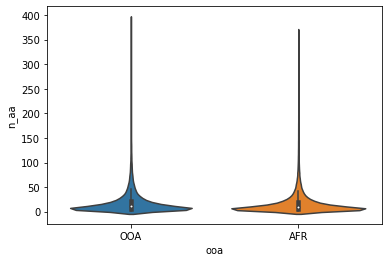

In [395]:
x = temp.loc[temp.ooa == 'AFR', 'n_aa'].tolist() # hypothesis is that this is greater\n",
y = temp.loc[temp.ooa == 'OOA', 'n_aa'].tolist()
    
stat, pval = st.ranksums(x, y, alternative='two-sided')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

ax = sns.violinplot(temp, x='ooa', y='n_aa')

Wilcoxon rank-sum test statistic: 14.18045010370226
Wilcoxon rank-sum test pval: 6.053376737273163e-46


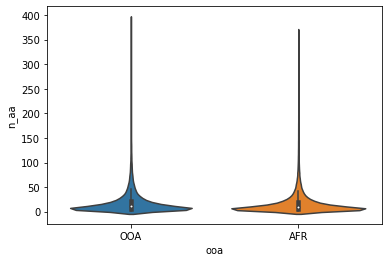

In [396]:
x = temp.loc[temp.ooa == 'AFR', 'n_aa_norm'].tolist() # hypothesis is that this is greater\n",
y = temp.loc[temp.ooa == 'OOA', 'n_aa_norm'].tolist()
    
stat, pval = st.ranksums(x, y, alternative='greater')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

ax = sns.violinplot(temp, x='ooa', y='n_aa')

In [398]:
# save
temp.to_csv('241121_aa_per_gene_per_pop.tsv', sep='\t')

## What about # ORFs / gene / sample between the OOA and Afr? 

In [399]:
# get expression levels for each transcript

f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
# df.set_index('tid', inplace=True)

In [400]:
temp = p_df[['tid', 'aa_id']].copy(deep=True)
temp.head()
l1 = len(temp.index)

In [401]:
temp = temp.merge(df, 
              how='inner',
              on='tid')
l2 = len(temp.index)
assert l1 == l2

In [402]:
# groupby aa_id and sum up 
temp.drop('tid', axis=1, inplace=True)
temp.groupby('aa_id').sum().reset_index()
temp.head()

,aa_id,YRI5,YRI6,YRI7,HAC1,HAC2,HAC3,HAC4,HAC5,HAC6,...,AJI6,CEU1,CEU2,CEU3,CEU4,CEU5,MPC4,YRI1,YRI2,YRI3
0,ENSG00000010219.14_MPASELKASEIPFHPSIKTQDPKAEEK...,121.415,177.8570,123.032,223.502,187.071,157.768,250.615,185.211,401.845,...,213.626,126.3090,83.361000,103.19,113.718000,177.243,127.606,157.835000,160.058,1.861810e+02
1,ENSG00000059804.18_MGTQKVTPALIFAITVATIGSFQFGYN...,0.000,12.9375,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,52.6313,0.000005,0.00,0.001145,0.000,0.000,0.174757,0.000,1.586700e-07
2,ENSG00000067646.12_MDEDEFELQPQEPNSFFDGIGADATHM...,0.000,0.0000,0.000,0.000,7.000,0.000,2.000,0.000,0.000,...,3.500,0.0000,0.000000,6.00,4.000000,0.000,0.000,0.000000,0.000,0.000000e+00
3,ENSG00000068308.15_MTILPKKKPPPPDADPANEPPPPGPMP...,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.0000,0.000000,0.00,0.000000,0.000,0.000,0.000000,0.000,0.000000e+00
4,ENSG00000074771.4_MMGCWILNEGLSTILVLSWLGINFYLFI...,0.000,0.0000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.0000,0.000000,0.00,0.000000,0.000,0.000,0.000000,0.000,0.000000e+00


In [403]:
# get melted version
temp.set_index('aa_id', inplace=True)
temp = temp.melt(value_name='counts', var_name='sample', ignore_index=False)

In [404]:
# remove everyting unexpressed
print(len(temp.index))
temp = temp.loc[temp.counts>=1]
print(len(temp.index))

3711158
1858040


In [405]:
# get gene id and 
temp =  temp.reset_index()
temp['gid'] = temp.aa_id.str.split('_', expand=True)[0]
temp.head()

,aa_id,sample,counts,gid
0,ENSG00000010219.14_MPASELKASEIPFHPSIKTQDPKAEEK...,YRI5,121.41500,ENSG00000010219.14
1,ENSG00000073331.18_MNNQKVVAVLLQECKQVLDQLLLEAPD...,YRI5,2.39075,ENSG00000073331.18
2,ENSG00000077150.21_MESCYNPGLDGIIEYDDFKLNSSIVEP...,YRI5,2.75306,ENSG00000077150.21
3,ENSG00000099219.15_MLEVLRVLSTSSEALHHAVIFLFNGAE...,YRI5,2.00000,ENSG00000099219.15
4,ENSG00000101846.9_MKIPFLLLFFLWEAESHAASRPNIILVM...,YRI5,1.66667,ENSG00000101846.9


In [406]:
# count number of aas / gene
temp = temp[['gid', 'aa_id', 'sample']].groupby(['sample', 'gid']).count().reset_index().rename({'aa_id':'n_aa'}, axis=1)

In [407]:
# add the metadata
temp = temp.merge(meta[['sample', 'ooa', 'population', 'map_reads_generalmap']], 
              how='left', on='sample')

In [408]:
# noramlize to read depth (aa / million reads)
temp['n_aa_norm'] = (temp['n_aa']/temp['map_reads_generalmap'])*1e6

In [409]:
temp.ooa.unique()

array(['OOA', 'AFR'], dtype=object)

Wilcoxon rank-sum test statistic: -4.01700696888928
Wilcoxon rank-sum test pval: 5.89419817196941e-05


<AxesSubplot:xlabel='ooa', ylabel='n_aa'>

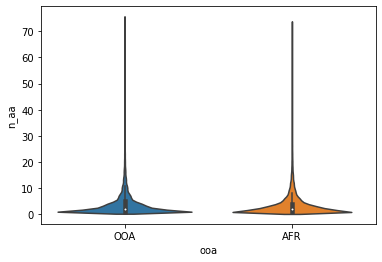

In [410]:
x = temp.loc[temp.ooa == 'AFR', 'n_aa'].tolist() # hypothesis is that this is greater\n",
y = temp.loc[temp.ooa == 'OOA', 'n_aa'].tolist()
    
stat, pval = st.ranksums(x, y, alternative='two-sided')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

sns.violinplot(temp, x='ooa', y='n_aa')

Wilcoxon rank-sum test statistic: 38.87462405542979
Wilcoxon rank-sum test pval: 0.0


<AxesSubplot:xlabel='ooa', ylabel='n_aa'>

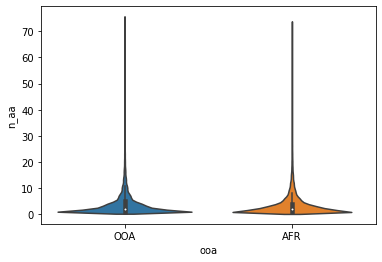

In [411]:
x = temp.loc[temp.ooa == 'AFR', 'n_aa_norm'].tolist() # hypothesis is that this is greater\n",
y = temp.loc[temp.ooa == 'OOA', 'n_aa_norm'].tolist()
    
stat, pval = st.ranksums(x, y, alternative='greater')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

sns.violinplot(temp, x='ooa', y='n_aa')

In [412]:
temp.to_csv('241121_aa_per_gene_per_sample.tsv', sep='\t')